# Add galaxy-galaxy strong lenses to DC2

As is well know, we have Sprinkler to add strong lensed AGNs in DDF. This notebook is for adding galaxy-galaxy strong lensing systems to DC2 in WFD. It is just a starting point, I will keep improving it. Should you have any questions or suggestions please feel free to slack me @linan7788626

In [1]:
%matplotlib inline

import numpy as np
import pylab as pl
import astropy.io.fits as pyfits
from astropy.table import Table

In [2]:
#--------------------------------------------------------------------
# Cosmology model
#

import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.045, h=0.71, A_s=2.1e-9, n_s=0.96)

vc = 2.998e5            # speed of light, km/s
G = 4.3011790220362e-09 # Gravity constant, Mpc/h (Msun/h)^-1 (km/s)^2
apr = 206269.43         # arcsec per rad

def Dc(z):
    '''
        Comoving distance from redshift 0 to redshift z.
    '''
    res = ccl.comoving_radial_distance(cosmo, 1/(1+z))*cosmo['h']
    return res

def Dc2(z1,z2):
    '''
        Comoving distance from redshift z1 to redshift z2.
    '''
    Dcz1 = ccl.comoving_radial_distance(cosmo, 1/(1+z1))*cosmo['h']
    Dcz2 = ccl.comoving_radial_distance(cosmo, 1/(1+z2))*cosmo['h']
    res = Dcz2-Dcz1+1e-8
    return res
 
def Da(z):
    '''
        Angular diameter distance from redshift 0 to redshift z.
    '''
    res = Dc(z)/(1+z)
    return res
 
def Da2(z1,z2):
    '''
        Angular diameter distance from redshift z1 to redshift z2.
    '''
    res = (Dc(z2)-Dc(z1)+1e-8)/(1.0+z2)
    return res

def Dl(z): 
    '''
        Luminosity distance from redshift 0 to redshift z.
    '''
    res = ccl.luminosity_distance(cosmo, 1/(1+z))*cosmo['h']
    return res 

def SigmaCrit(z1,z2):
    '''
        Critical surface density for the case of lens plane at z1 and source plane at z2.
    '''
    res = (vc*vc/4.0/np.pi/G*Dc(z2)/(Dc(z1)/(1.0+z1))/Dc2(z1,z2))
    return res

In [4]:
def mags_to_vd(mg,mr,zz):
    '''
        Calculate the velocity dispersion of a galaxy according its apparent magnitudes in g and r bands.
        Faber et al. 2007 
        Parker et al. 2007, Table 1
        --- any suggestions on involving more realistic models? ---
    '''
    Dlum     = Dl(zz)
    Mabsr    = mr-5.0*np.log10(Dlum/cosmo['h'])-25.0
    mrsdss   = Mabsr+0.024*(mg-mr)/0.871
    mrsdss   = mrsdss-0.11
    mrstar   = (-20.44)+(zz-0.1)*1.5
    LbyLstar = 10.0**(-0.4*(mrsdss-mrstar))
    res      = 142.0*LbyLstar**(1./3.)
    return res

def re_sv(sv,z1,z2):
    '''
        Einstein Radius for an galaxy with velocity dispersion sv at redshift z1, 
        and the redshift of source plane is z2. The mass model of the galaxy is 
        Singular Isothermal Ellipsoid (Kormann et al. 1994).
    '''
    res = 4.0*np.pi*(sv**2.0/vc**2.0)*Da2(z1,z2)/Da(z2)*apr
    return res

def sersic_2d_hist_phosim(xi1, xi2, xc1, xc2, a_major, b_minor, pha, ndex=1.0):
    '''
        Sersic Profile from the document of PhoSim
    '''
    bn = 2.0*ndex-1/3.0+0.009876/ndex
    phirad = np.deg2rad(pha)
    xi1new = (xi1-xc1)*np.cos(phirad)+(xi2-xc2)*np.sin(phirad)
    xi2new = (xi2-xc2)*np.cos(phirad)-(xi1-xc1)*np.sin(phirad)
    R_scale = np.sqrt((xi1new/a_major)**2+(xi2new/b_minor)**2)
    R_scale[R_scale<0.1] = 0.1
    img = np.exp(-bn*((R_scale)**(1.0/ndex)-1.0))
    res = img/np.exp(-bn*((0.1)**(1.0/ndex)-1.0))
    return res

def ftot_mb(mag_in, zpoint):
    '''
        Total pixel value of an image based on given apparent magnitudes and the zeropoint
    '''
    res = 10.0**((zpoint - mag_in)*0.4)
    return res

def make_c_coor(bs,nc):
    '''
        Draw the mesh grids for a bs*bs box with nc*nc pixels
    '''
    ds = bs/nc
    xx01 = np.linspace(-bs/2.0,bs/2.0-ds,nc)+0.5*ds
    xx02 = np.linspace(-bs/2.0,bs/2.0-ds,nc)+0.5*ds
    xi2,xi1 = np.meshgrid(xx01,xx02)
    return xi1,xi2

In [5]:
def sie_alphas_simple(x0, y0, theta, ql, re, le, ext_shears, ext_angle, ext_kappa, x, y, rc=0.0):  
    # Singular Isothermal Ellipsoid (SIE) lens model
    '''
        Calculate deflection maps for an SIE lens with external shear and external convergence.
            * x0, y0 stand for the position of the lens
            * theta is the position angle of the lens
            * ql is the axis ratio of the lens
            * re is Einstein Radius
            * le is the scale factor due to projection effects
            * ext_shears is the amplitude of external shear
            * ext_angle is the position angle of external shear
            * ext_kappa is the amplitude of external convergence
            * x, y are the positions that you want to calculate the deflection angles
            * rc is the core size for a non-singular isothermal module for an SIE model, rc=0 by default.
        please see Appendix B in [http://www.slac.stanford.edu/~oguri/glafic/misc/man_glafic.pdf] 
        for more details.
    '''
    tr = np.pi * (theta / 180.0) + np.pi / 2.0

    sx = x - x0
    sy = y - y0

    cs = np.cos(tr)
    sn = np.sin(tr)

    sx_r =  sx * cs + sy * sn
    sy_r = -sx * sn + sy * cs

    fq = np.sqrt((1.0 + ql**2.0)/(2.0*ql**2.0))
    bq = re*fq
    
    eql = np.sqrt(ql / (1.0 - ql**2.0))
    psi = np.sqrt(sx_r**2.0 * ql + sy_r**2.0 / ql)
    dx_tmp = (bq * np.sqrt(ql) * eql * np.arctan( sx_r / psi / eql))
    dy_tmp = (bq * np.sqrt(ql) * eql * np.arctanh(sy_r / psi / eql))

    dx = dx_tmp * cs - dy_tmp * sn
    dy = dx_tmp * sn + dy_tmp * cs

    # external shear
    tr2 = np.pi * (ext_angle / 180.0)
    cs2 = np.cos(2.0 * tr2)
    sn2 = np.sin(2.0 * tr2)
    dx2 = ext_shears * (cs2 * sx + sn2 * sy)
    dy2 = ext_shears * (sn2 * sx - cs2 * sy)

    # external kappa
    dx3 = ext_kappa * sx
    dy3 = ext_kappa * sy
    return dx*le + dx2 + dx3, dy*le + dy2 + dy3

In [6]:
# #--------------------------------------------------------------------
# # Load in the extragalactic catalog from cosmoDC2
# #

# import GCRCatalogs
# gc = GCRCatalogs.load_catalog('cosmoDC2_v1.0_small')

In [7]:
# #----------------------------------
# # grab the parameters for generating the SIE model of lenses (BCGs only)
# #
# %time

# bcgs_data_dict = gc.get_quantities(['galaxyID', 
#                                     'ra_true',
#                                     'dec_true',
#                                     'redshift_true',
#                                     'mag_true_g_lsst', 
#                                     'mag_true_r_lsst',
#                                     'is_central'],
#                                     filters=['is_central==True'])

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.1 µs


In [8]:
# #----------------------------------
# # Save the parameters of the BCGs (lenses)
# #
# %time

# bcgs_data_table = Table()
# bcgs_data_table['galaxyID']           =  bcgs_data_dict['galaxyID']
# bcgs_data_table['ra_true']            =  bcgs_data_dict['ra_true']
# bcgs_data_table['dec_true']           =  bcgs_data_dict['dec_true']
# bcgs_data_table['dec_true']           =  bcgs_data_dict['dec_true']
# bcgs_data_table['mag_true_g_lsst']    =  bcgs_data_dict['mag_true_g_lsst']
# bcgs_data_table['mag_true_r_lsst']    =  bcgs_data_dict['mag_true_r_lsst']
# bcgs_data_table['redshift_true']      =  bcgs_data_dict['redshift_true']
# del bcgs_data_dict
# bcgs_data_table.write("bcgs_centers_database.hdf5", path='/bcgs', append=True, overwrite=True)
# del bcgs_data_table

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 7.87 µs


In [9]:
# #----------------------------------
# # grab basic parameters of the galaxies which could be potential sources
# #
# %time

# gals_data_dict = gc.get_quantities(['galaxyID', 
#                           'ra_true',
#                           'dec_true',
#                           'size_true',
#                           'size_minor_true',
#                           'position_angle_true', 
#                           'redshift_true', 
#                           'stellar_mass', 
#                           'halo_mass', 
#                           'is_central'],
#                           filters=[])

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 9.78 µs


In [10]:
# #----------------------------------
# # save the basic parameters of sources
# #
# %time

# gals_data_table = Table()
# gals_data_table['galaxyID']           =  gals_data_dict['galaxyID']
# gals_data_table['ra_true']            =  gals_data_dict['ra_true']
# gals_data_table['dec_true']           =  gals_data_dict['dec_true']
# gals_data_table['size_major_true']    =  gals_data_dict['size_true']**2.0/gals_data_dict['size_minor_true']
# gals_data_table['size_minor_true']    =  gals_data_dict['size_minor_true']
# gals_data_table['position_angle_true']=  gals_data_dict['position_angle_true']
# gals_data_table['redshift_true']      =  gals_data_dict['redshift_true']
# gals_data_table['stellar_mass']       =  gals_data_dict['stellar_mass']
# gals_data_table['halo_mass']          =  gals_data_dict['halo_mass']
# gals_data_table['is_central']         =  gals_data_dict['is_central']
# del gals_data_dict
# gals_data_table.write("ggsl_database.hdf5", path='/ggsl', append=True, overwrite=True)
# del gals_data_table

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 8.11 µs


In [11]:
# #----------------------------------
# # read in apparent magnitudes of sources
# #
# %time

# mags_data_dict = gc.get_quantities(['galaxyID',  
#                                     'mag_true_u_lsst',
#                                     'mag_true_g_lsst', 
#                                     'mag_true_r_lsst',
#                                     'mag_true_i_lsst',
#                                     'mag_true_z_lsst'],
#                                     filters=[])

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.58 µs


In [13]:
# #----------------------------------
# # save the apparent magnitudes of sources
# #
# %time

# mags_data_table = Table()
# mags_data_table['galaxyID']           =  mags_data_dict['galaxyID']
# mags_data_table['mag_true_u_lsst']    =  mags_data_dict['mag_true_u_lsst']
# mags_data_table['mag_true_g_lsst']    =  mags_data_dict['mag_true_g_lsst']
# mags_data_table['mag_true_r_lsst']    =  mags_data_dict['mag_true_r_lsst']
# mags_data_table['mag_true_i_lsst']    =  mags_data_dict['mag_true_i_lsst']
# mags_data_table['mag_true_z_lsst']    =  mags_data_dict['mag_true_z_lsst']
# del mags_data_dict

# mags_data_table.write("ggsl_database.hdf5", path='/mags', append=True, overwrite=True)
# del mags_data_table

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.3 µs


In [14]:
# #----------------------------------
# # read in morphological properties of sources
# #
# %time

# morph_data_dict = gc.get_quantities(['galaxyID', 
#                           'size_disk_true', 
#                           'size_minor_disk_true', 
#                           'sersic_disk', 
#                           'size_bulge_true', 
#                           'size_minor_bulge_true', 
#                           'sersic_bulge', 
#                           'bulge_to_total_ratio_i'],
#                           filters=[])

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 11.7 µs


In [15]:
# #----------------------------------
# # save morphological properties of sources
# #
# %time

# morph_data_table = Table()
# morph_data_table['galaxyID']                 =  morph_data_dict['galaxyID']
# morph_data_table['size_major_disk_true']     =  morph_data_dict['size_disk_true']**2.0/morph_data_dict['size_minor_disk_true']
# morph_data_table['size_minor_disk_true']     =  morph_data_dict['size_minor_disk_true']
# morph_data_table['sersic_disk']              =  morph_data_dict['sersic_disk']
# morph_data_table['size_major_bulge_true']    =  morph_data_dict['size_bulge_true']**2.0/morph_data_dict['size_minor_bulge_true']
# morph_data_table['size_minor_bulge_true']    =  morph_data_dict['size_minor_bulge_true']
# morph_data_table['sersic_bulge']             =  morph_data_dict['sersic_bulge']
# morph_data_table['bulge_to_total_ratio_i']   =  morph_data_dict['bulge_to_total_ratio_i']
# del morph_data_dict

# morph_data_table.write("ggsl_database.hdf5", path='/morph', append=True, overwrite=True)
# del morph_data_table

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [16]:
#----------------------------------
# After saving necessary data to hdf5 files
# I create this class to load in needed data for the lensing simulations.
# It means that one only needs to run the above cells once.
#

class loadinData(object):
    def __init__(self, fileggls="ggsl_database.hdf5", filebcgs="bcgs_centers_database.hdf5"):
        self.fileggls = fileggls
        self.filebcgs = filebcgs

    def loadinGals(self):
        ggsl_data = Table.read(self.fileggls, path='/ggsl')
        return ggsl_data
    
    def loadinMags(self):
        mags_data = Table.read(self.fileggls, path='/mags')
        return mags_data
    
    def loadinMorph(self):
        morph_data = Table.read(self.fileggls, path='/morph')
        return morph_data
    
    def loadinBCGs(self):
        bcgs_data = Table.read(self.filebcgs, path='/bcgs')
        return bcgs_data

In [17]:
#----------------------------------
# load in the parameters for lensing simulations, 
# including mass models of lenses
# and light models of sources.
#

ggsl_database = "./ggsl_database.hdf5"
ggsl_data = loadinData(ggsl_database)

In [18]:
#----------------------------------
# convert astropy tables to arrays.
# It is not neccesary, I involve this to avoid typing long names :-)
#

# overviews of sources
gals_data = ggsl_data.loadinGals()
sid    = gals_data['galaxyID']
sra    = gals_data['ra_true']
sdec   = gals_data['dec_true']
szphot = gals_data['redshift_true']
sta    = gals_data['size_major_true']
stb    = gals_data['size_minor_true']
spang  = gals_data['position_angle_true']
del gals_data

# luminosity of sources
mags_data = ggsl_data.loadinMags()
smag_u = mags_data['mag_true_u_lsst']
smag_g = mags_data['mag_true_g_lsst']
smag_r = mags_data['mag_true_r_lsst']
smag_i = mags_data['mag_true_i_lsst']
smag_z = mags_data['mag_true_z_lsst']
del mags_data

# morphologies of sources
morph_data = ggsl_data.loadinMorph()
sda    = morph_data['size_major_disk_true']
sdb    = morph_data['size_minor_disk_true']
sdn    = morph_data['sersic_disk']
sba    = morph_data['size_major_bulge_true']
sbb    = morph_data['size_minor_bulge_true']
sbn    = morph_data['sersic_bulge']
sfrac  = morph_data['bulge_to_total_ratio_i']
del morph_data

In [19]:
#----------------------------------
# load in the properties of the lenses
# for the calculation of Einstein Radii
#

bcgs_data = ggsl_data.loadinBCGs()
ra_main  = bcgs_data['ra_true']
dec_main = bcgs_data['dec_true']
zl_main  = bcgs_data['redshift_true']
magg_main= bcgs_data['mag_true_g_lsst']
magr_main= bcgs_data['mag_true_r_lsst']
del bcgs_data

In [25]:
print(len(zl_main))

430510630


In [21]:
#----------------------------------
# Create catalogs of lensing systems for selected stamps (light cones)
# 430510630
    
# parameters of this image simulation, updated them as you will
nnn = 1024 # number of pixels per side
bsz_arc = 20.0 # box size per side, in units of arcsec
bsz_deg = bsz_arc/3600.0  # box size per side, in units of degree
zpoints = 30.0 # the zeropoint of LSST
zs0 = 10.0     # redshift of the referencial source plane

n_runs = 1000000 # number of attempts to create strong lenses by visiting each BCGs from cosmoDC2. 
                 # After skipping the light cones which are excluded 
                 # according to the selection criterions (e.g., redshifts, mass...), 
                 # the number of outputs would be much smaller than n_runs.

for i in range(n_runs):
    # choose the lenses with redshifts larger than 0.5 (or any number you want)
    if zl_main[i] < 0.5: 
        continue
    
    vd_main = mags_to_vd(magg_main[i], magr_main[i], zl_main[i])
    re_main = re_sv(vd_main,zl_main[i],zs0)
    
    # choose the lenses with Einstein Radii larger than 2.5 (or any number you want)
    if re_main<2.5:
        continue
    
    # convert ra/dec of sources to arcsec with respect to the centers of lenses
    xsr1 = (sra-ra_main[i])*3600.0
    xsr2 = (sdec-dec_main[i])*3600.0

    # drop off the sources beyond the box centered at the lenses
    idx1 = xsr1 > -bsz_arc/2.0
    idx2 = xsr1 <= bsz_arc/2.0
    idx3 = xsr2 > -bsz_arc/2.0
    idx4 = xsr2 <= bsz_arc/2.0

    idx = idx1&idx2&idx3&idx4
    
    # print the number of galaxies in the light cone
    nsrcs = len(sid[idx])
    print(i, nsrcs)

    # create the catalog of the sources in the box centered at the lens
    srcs_lc_cat = Table()
    
    srcs_lc_cat['isMain'] = np.array(sid[idx]*0.0, dtype=int)
    srcs_lc_cat['SID'] = sid[idx]
    srcs_lc_cat['xs1'] = xsr1[idx]
    srcs_lc_cat['xs2'] = xsr2[idx]
    srcs_lc_cat['szs'] = szphot[idx]
    
    srcs_lc_cat['sta'] = sta[idx]               
    srcs_lc_cat['stb'] = stb[idx]
    
    srcs_lc_cat['sda'] = sda[idx]               
    srcs_lc_cat['sdb'] = sdb[idx]
    srcs_lc_cat['sdn'] = sdn[idx]
    
    srcs_lc_cat['sba'] = sba[idx]               
    srcs_lc_cat['sbb'] = sbb[idx]
    srcs_lc_cat['sbn'] = sbn[idx]

    srcs_lc_cat['spa'] = spang[idx]
    srcs_lc_cat['sfc'] = sfrac[idx]

    srcs_lc_cat['magu'] = smag_u[idx]
    srcs_lc_cat['magg'] = smag_g[idx]
    srcs_lc_cat['magr'] = smag_r[idx]
    srcs_lc_cat['magi'] = smag_i[idx]
    srcs_lc_cat['magz'] = smag_z[idx]
    
    # sort the galaxies in the light cone according to the distance to the center of the lens
    # and set the galaxy on top of the center of the lens as the "main galaxy"
    idx_cen = np.argmin(np.sqrt(srcs_lc_cat['xs1']**2.0+srcs_lc_cat['xs2']**2.0))
    srcs_lc_cat['isMain'][idx_cen] = 1

    # save all parameters for simulating the lens in the light cone.
    filename = "./slc_data/slc_" + str(i) + "_" + str(nsrcs) + "_cats.hdf5"
    srcs_lc_cat.write(filename, path='/srcs', append=True, overwrite=True)

328307 149
329277 134
329982 151
330720 123
331928 156
332680 128
333469 137
334139 149
336052 146
391804 145
392712 107
394015 128
400037 140
402076 131
402121 151
402622 133
402897 154
403096 131
403550 121
403586 142
405142 131
407741 131
489132 143
566363 151
566485 147
567810 153
567900 159
569078 119
570631 161
571501 161
572020 127
572849 138
572974 163
573881 137
647143 150
647697 147
648107 119
648215 131
649020 150
649049 126
649429 125
649646 140
650727 130
650987 143
651108 145
651243 150
652036 128
652047 143
653234 154
653718 150
653868 154
654393 129
654914 146
655382 147
655394 138
658086 129
658317 132
659668 141
659714 134
659728 140
659743 155
661989 127
662363 139
662584 122
663737 155
663798 131
674719 125
751381 114
752605 135
753907 172
754827 138
755139 159
757732 147
757901 145
757922 134
758458 137
758781 117
759686 102
760783 134
761450 154
761703 120
763730 128
764687 141
764734 143
766016 121
766669 149
869421 131
871024 147
872293 142
873310 147
874518 118

In [28]:
def main_run(srcs_cat, nonlensing=False, nonbcgs=False, plot_images=True):
    '''
        Create lensed images by feeding the catalog of the light cone genereated above.
        One srcs_cat is used to generate one lensing system.
    '''

    # Coordinates of the grids in images planes
    xi1,xi2 = make_c_coor(bsz_arc,nnn)
    
    # Initialize lensed images in ugriz bands
    lensed_images_u = np.zeros((nnn, nnn))
    lensed_images_g = np.zeros((nnn, nnn))
    lensed_images_r = np.zeros((nnn, nnn))
    lensed_images_i = np.zeros((nnn, nnn))
    lensed_images_z = np.zeros((nnn, nnn))

    # Calculate deflection maps of the lens in this light cone
    idx_main  = srcs_cat['isMain']==1
    magg_lens = srcs_cat['magg'].data[idx_main][0]
    magr_lens = srcs_cat['magr'].data[idx_main][0]
    ql_lens   = srcs_cat['stb'].data[idx_main][0]/srcs_cat['sta'].data[idx_main][0]
    pa_lens   = srcs_cat['spa'].data[idx_main][0]
    zl_lens   = srcs_cat['szs'].data[idx_main][0]

    vd_lens = mags_to_vd(magg_lens, magr_lens, zl_lens)
    re_lens = re_sv(vd_lens,zl_lens,zs0)

    al1_ref, al2_ref = sie_alphas_simple(0.0, 0.0, pa_lens, ql_lens, re_lens, 
                                         1.0, 0.0, 0.0, 0.0, 
                                         xi1, xi2)
    # Generate lensed images of all galaxies in the light cone based on the deflection angles maps
    for j in range(len(srcs_cat['SID'])):
        zs   = srcs_cat['szs'][j]
        ys1  = srcs_cat['xs1'][j]
        ys2  = srcs_cat['xs2'][j]
        
        # remove the image of BCGs if nonbcgs is set to True
        if nonbcgs:
            rys = np.sqrt(ys1*ys1 + ys2*ys2)
            if rys == 0.0:
                continue

        sda  = srcs_cat['sda'][j]
        sdb  = srcs_cat['sdb'][j]
        sdn  = srcs_cat['sdn'][j]

        sba  = srcs_cat['sba'][j]
        sbb  = srcs_cat['sbb'][j]
        sbn  = srcs_cat['sbn'][j]

        spa  = srcs_cat['spa'][j]
        sfc  = srcs_cat['sfc'][j]

        magu = srcs_cat['magu'][j]
        magg = srcs_cat['magg'][j]
        magr = srcs_cat['magr'][j]
        magi = srcs_cat['magi'][j]
        magz = srcs_cat['magz'][j]

        if nonlensing:
            yi1, yi2 = xi1, xi2
        else:
            if zs <= zl_lens:
                yi1 = xi1
                yi2 = xi2
            else:        
                rescale = Da(zs0)/Da2(zl_lens,zs0)*Da2(zl_lens,zs)/Da(zs)
                al1_zs = al1_ref*rescale
                al2_zs = al2_ref*rescale
                yi1 = xi1 - al1_zs
                yi2 = xi2 - al2_zs       
        
        # lensed disks
        ss_tmp_disk  = sersic_2d_hist_phosim(yi1, yi2, ys1, ys2, sda, sdb, spa, sdn)
        sum_ss_disk  = ss_tmp_disk.sum()
        if sum_ss_disk > 0.0:
            sfactor_u_disk  = ftot_mb(magu, zpoints)*(1.0-sfc)/sum_ss_disk
            sfactor_g_disk  = ftot_mb(magg, zpoints)*(1.0-sfc)/sum_ss_disk
            sfactor_r_disk  = ftot_mb(magr, zpoints)*(1.0-sfc)/sum_ss_disk
            sfactor_i_disk  = ftot_mb(magi, zpoints)*(1.0-sfc)/sum_ss_disk
            sfactor_z_disk  = ftot_mb(magz, zpoints)*(1.0-sfc)/sum_ss_disk
        else:
            sfactor_u_disk  = 0.0
            sfactor_g_disk  = 0.0
            sfactor_r_disk  = 0.0
            sfactor_i_disk  = 0.0
            sfactor_z_disk  = 0.0
        
        # lensed bulges
        ss_tmp_bulge = sersic_2d_hist_phosim(yi1, yi2, ys1, ys2, sba, sbb, spa, sbn)
        sum_ss_bulge = ss_tmp_bulge.sum()
        if sum_ss_bulge > 0.0:
            sfactor_u_bulge = ftot_mb(magu, zpoints)*sfc/sum_ss_bulge
            sfactor_g_bulge = ftot_mb(magg, zpoints)*sfc/sum_ss_bulge
            sfactor_r_bulge = ftot_mb(magr, zpoints)*sfc/sum_ss_bulge
            sfactor_i_bulge = ftot_mb(magi, zpoints)*sfc/sum_ss_bulge
            sfactor_z_bulge = ftot_mb(magz, zpoints)*sfc/sum_ss_bulge
        else:
            sfactor_u_bulge = 0.0
            sfactor_g_bulge = 0.0
            sfactor_r_bulge = 0.0
            sfactor_i_bulge = 0.0
            sfactor_z_bulge = 0.0
        
        # stack all images together 
        lensed_images_u = lensed_images_u + ss_tmp_disk*sfactor_u_disk + ss_tmp_bulge*sfactor_u_bulge
        lensed_images_g = lensed_images_g + ss_tmp_disk*sfactor_g_disk + ss_tmp_bulge*sfactor_g_bulge
        lensed_images_r = lensed_images_r + ss_tmp_disk*sfactor_r_disk + ss_tmp_bulge*sfactor_r_bulge
        lensed_images_i = lensed_images_i + ss_tmp_disk*sfactor_i_disk + ss_tmp_bulge*sfactor_i_bulge
        lensed_images_z = lensed_images_z + ss_tmp_disk*sfactor_z_disk + ss_tmp_bulge*sfactor_z_bulge
    
        del ss_tmp_disk, ss_tmp_bulge
    
    # visualize the lensed images
    if plot_images:
        image_title=''
        if nonlensing and nonbcgs:
            image_title=="Unlensed light cone without lens light"
        if nonlensing and nonbcgs==False:
            image_title=="Unlensed light cone with lens light"
        if nonlensing==False and nonbcgs:
            image_title=="lensed light cone without lens light"
        if nonlensing==False and nonbcgs==False:
            image_title="lensed light cone with lens light"

        pl.figure(figsize=(9,9))
        pl.title(image_title)
        pl.imshow(np.log10(lensed_images_u))
    
    return 0

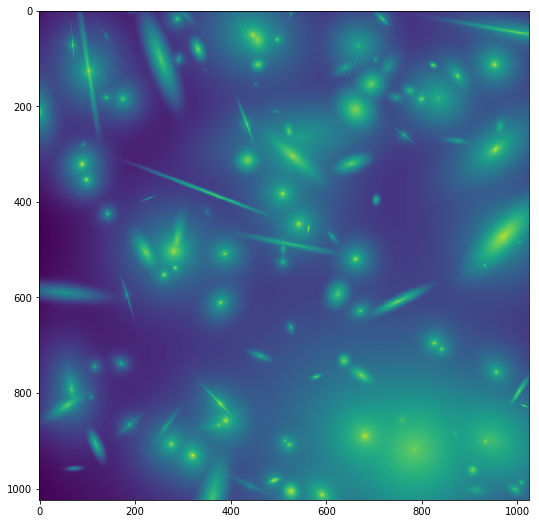

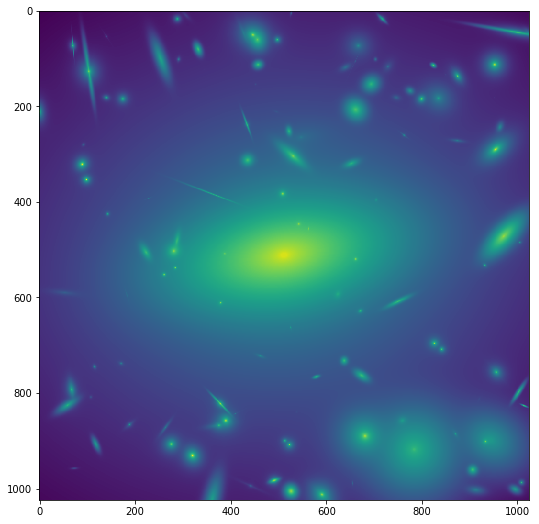

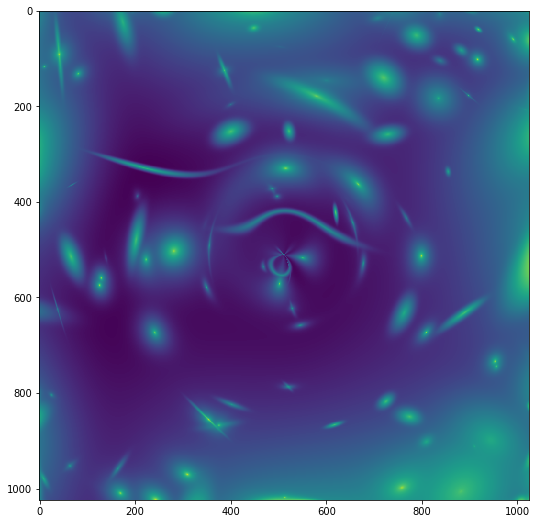

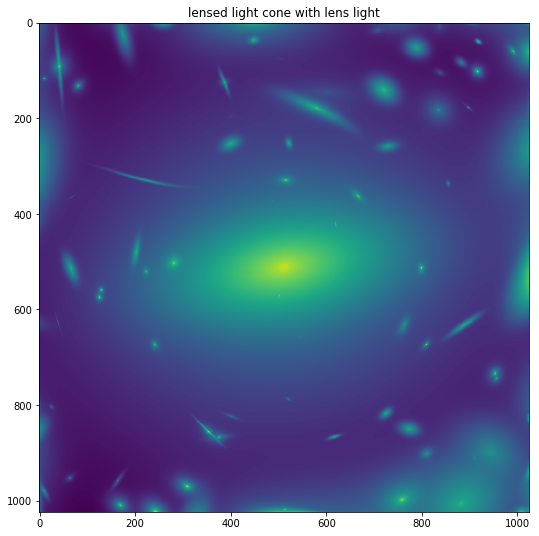

In [29]:
# directory for saving the data of lenses and sources
work_dir = "/global/projecta/projectdirs/lsst/groups/SL/users/nanli/Projects/GG_SL_DC2/" 

# directory for saving catalogs of light cones
slc_data_dir = work_dir + "slc_data/"

# generate strongly lensed images by inputting a light cone catalog
srcs_cat_t = Table.read(slc_data_dir+"slc_329277_135_cats.hdf5", path='/srcs')
main_run(srcs_cat_t, nonlensing=True,  nonbcgs=True) # images without lensing effects and BCGs
main_run(srcs_cat_t, nonlensing=True,  nonbcgs=False)# images without lensing effects but with BCGs
main_run(srcs_cat_t, nonlensing=False, nonbcgs=True) # images with lensing effects but without BCGs
main_run(srcs_cat_t, nonlensing=False, nonbcgs=False)# images with lensing effects and BCGs
del srcs_cat_t